In [255]:
import pandas as pd
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt



## Normalise the data

Including: 
* Remove stations with no rain records ever
* Remove stations without coordinates
* Remove the "Summary" rows of data


In [256]:
# read in the just data we're interested in 
df = pd.read_csv("data.csv", usecols=['date', 'lat', 'lon', 'station', 'prec_mm'])
# we're interested in precipitation; replace "Tr" (trace) with arbitrarily small figure
df['prec_mm'] = pd.to_numeric(df['prec_mm'].str.replace("Tr", "0.01"))
df = df.fillna(0)
# There are summary rows in the data; remove those
df = df[(~pd.isnull(df.lat)) & (df.station != 'Summary')]

In [257]:
# Allow us to average over years
df['month-day'] = df['date'].str.replace(r".*-(\d+)-(\d+)", r"\1-\2")

# Create a categorical variable: did it rain at all?
df['rained'] = df.prec_mm.apply(lambda x: 1 if x > 0 else 0)

In [258]:
# Prune stations with not-so-many data points
counts = df.groupby('station').count()
stations_with_data = df.merge(counts[counts.date > 0.85*len(counts)], how='inner', on='station', suffixes=['', '_y'])
# remove stations where there's never been any rain - presumably they don't measure it
stations_with_data = stations_with_data.merge(max_rained[max_rained.rained > 0.0], how='inner', on='station', suffixes=['', '_y'])
# Average across all years of data
stations_with_data = stations_with_data.groupby(['month-day', 'station']).mean()
stations_with_data = stations_with_data[['lat','lon','prec_mm','rained']]
stations_with_data.head()


lat    lon   prec_mm    rained
month-day station                                           
01-01     Aberdaron        52.783 -4.733  3.560000  1.000000
          Aberdeen / Dyce  57.200 -2.217  0.940000  0.700000
          Aberporth        52.133 -4.567  3.701000  0.900000
          Aboyne           57.083 -2.833  1.314444  0.777778
          Albemarle        55.017 -1.867  2.301000  0.900000

## Compute Voneroi regions for each weather station

In [259]:
df = stations_with_data.copy()
# Compute vonoroi regions for each point
df['coordinates'] = list(zip(df.lon, df.lat))
df['coordinates'] = df['coordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(df, geometry='coordinates')

In [260]:
%load_ext autoreload
%autoreload 2
%aimport compute


import compute



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
from scipy.spatial import Voronoi
import numpy as np
one_month = gdf.loc['01-01']
locations = np.array([tuple(x) for x in one_month[['lon', 'lat']].values])
bounding_box = np.array([
    one_month.lon.min(), one_month.lon.max(), one_month.lat.min(), one_month.lat.max()
]) # [x_min, x_max, y_min, y_max]
vor = compute.voronoi(locations, bounding_box)




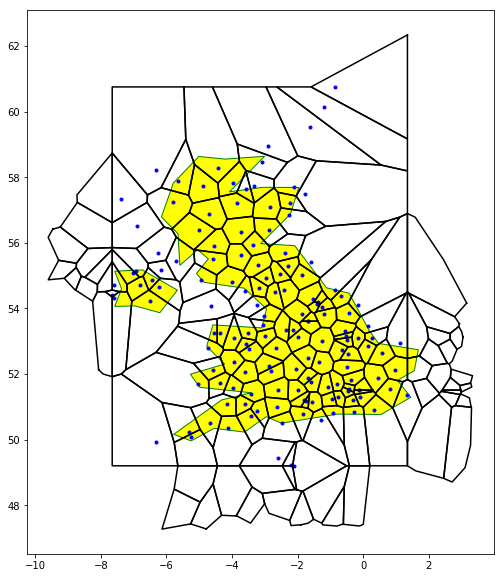

In [262]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12,10))
ax = fig.gca()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world[world.name == 'United Kingdom'].plot(ax=ax,
    color='yellow', edgecolor='green')

# Plot initial points
ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')

# Plot ridges
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')
# Compute and plot centroids



In [263]:
from shapely.geometry import Point, LineString, Polygon
polygons = []
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    #print(vertices)
    #ax.plot(vertices[:, 0], vertices[:, 1], 'k-')
    polygons.append(Polygon(vertices))

In [264]:
# now pick the polygon that each station belongs to
poly_df = geopandas.GeoDataFrame(geometry=polygons)
data_with_polygons = geopandas.sjoin(poly_df,gdf.reset_index(), how="inner", op='intersects')


In [265]:
data_with_polygons = data_with_polygons.set_index(['month-day', 'station'])

## Plot the data

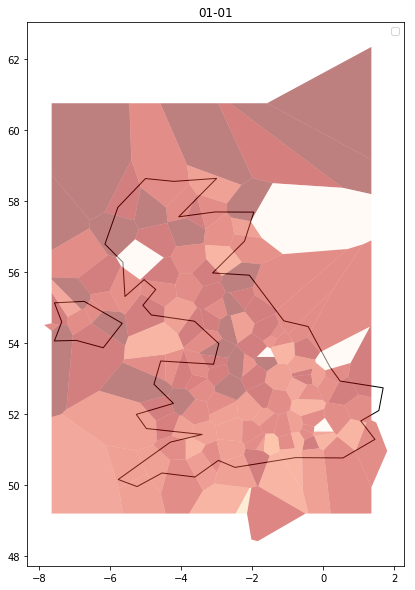

In [266]:
months_to_plot = 1  # - 1 for all
for m_d in asd.index.levels[0][:months_to_plot]:
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.legend(m_d, loc='best')
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world[world.name == 'United Kingdom'].plot(ax=ax,
        color='white', edgecolor='black')
    data_with_polygons.loc[m_d].plot(ax=ax, alpha=0.5, cmap='OrRd', column='rained')
    plt.title(m_d)
    plt.savefig("{}.png".format(m_d))